Implementation of the original diffusion model.

Credits to Maxime Vandegar for the code and the Youtube Tutorial, which can be seen [here](https://github.com/MaximeVandegar/Papers-in-100-Lines-of-Code/blob/main/Deep_Unsupervised_Learning_using_Nonequilibrium_Thermodynamics/diffusion_models.py) and [here](https://www.youtube.com/watch?v=ScbNXhZ8L9U).

A few functions were added to:
* save the checkpoint after training (Chapter 1)
* generate a sample dataset (Chapter 2)
* visualize the diffusion rate (Chapter 2)
* plot the forward process (Chapter 2)
* plot outcomes of the training pocess (Chapter 2)
* plot the reverse process (Chapter 2)
* load a checkpoint and rerun a trained model (Chapter 3)


# Chapter 1: Reimplementation of the model

In [ ]:
# from
import torch
import numpy as np
from torch import nn
from tqdm import tqdm
import torch.utils.data
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

In [ ]:
def sample_batch(size):
    x, _ = make_swiss_roll(size)
    return x[:, [2, 0]] / 10.0 * np.array([1, -1])

In [ ]:
class MLP(nn.Module):

    def __init__(self, N=40, data_dim=2, hidden_dim=64):
        super(MLP, self).__init__()

        self.network_head = nn.Sequential(nn.Linear(data_dim, hidden_dim), nn.ReLU(),
                                          nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), )
        self.network_tail = nn.ModuleList([nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                                         nn.ReLU(), nn.Linear(hidden_dim, data_dim * 2)
                                                         ) for _ in range(N)])

    def forward(self, x, t: int):
        h = self.network_head(x)
        return self.network_tail[t](h)

In [ ]:
class DiffusionModel(nn.Module):

    def __init__(self, model: nn.Module, n_steps=40, device='cuda'):
        super().__init__()

        self.model = model
        self.device = device

        betas = torch.linspace(-18, 10, n_steps)
        self.beta = torch.sigmoid(betas) * (3e-1 - 1e-5) + 1e-5 # diffusion rate

        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0) # cumulative product of alphas
        self.n_steps = n_steps
        self.sigma2 = self.beta

    def forward_process(self, x0, t):

        t = t - 1  # Start indexing at 0
        beta_forward = self.beta[t]
        alpha_forward = self.alpha[t]
        alpha_cum_forward = self.alpha_bar[t]
        xt = x0 * torch.sqrt(alpha_cum_forward) + torch.randn_like(x0) * torch.sqrt(1. - alpha_cum_forward)
        # Retrieved from https://github.com/Sohl-Dickstein/Diffusion-Probabilistic-Models/blob/master/model.py#L203
        mu1_scl = torch.sqrt(alpha_cum_forward / alpha_forward)
        mu2_scl = 1. / torch.sqrt(alpha_forward)
        cov1 = 1. - alpha_cum_forward / alpha_forward
        cov2 = beta_forward / alpha_forward
        lam = 1. / cov1 + 1. / cov2
        mu = (x0 * mu1_scl / cov1 + xt * mu2_scl / cov2) / lam
        sigma = torch.sqrt(1. / lam)
        return mu, sigma, xt

    def reverse(self, xt, t):

        t = t - 1  # Start indexing at 0
        if t == 0: return None, None, xt
        mu, h = self.model(xt, t).chunk(2, dim=1)
        sigma = torch.sqrt(torch.exp(h))
        samples = mu + torch.randn_like(xt) * sigma
        return mu, sigma, samples

    def sample(self, size, device):
        noise = torch.randn((size, 2)).to(device)
        samples = [noise]
        for t in range(self.n_steps):
            _, _, x = self.reverse(samples[-1], self.n_steps - t - 1 + 1)
            samples.append(x)
        return samples


In [ ]:
def plot_3(model):
    plt.figure(figsize=(10, 6))
    x0 = sample_batch(5000)
    x20 = model.forward_process(torch.from_numpy(x0).to(device), 20)[-1].data.cpu().numpy()
    x40 = model.forward_process(torch.from_numpy(x0).to(device), 40)[-1].data.cpu().numpy()
    data = [x0, x20, x40]
    for i, t in enumerate([0, 20, 39]):
        plt.subplot(2, 3, 1 + i)
        plt.scatter(data[i][:, 0], data[i][:, 1], alpha=.1, s=1)
        plt.xlim([-2, 2])
        plt.ylim([-2, 2])
        plt.gca().set_aspect('equal')
        if t == 0: plt.ylabel(r'$q(\mathbf{x}^{(0...T)})$', fontsize=17, rotation=0, labelpad=60)
        if i == 0: plt.title(r'$t=0$', fontsize=17)
        if i == 1: plt.title(r'$t=\frac{T}{2}$', fontsize=17)
        if i == 2: plt.title(r'$t=T$', fontsize=17)

    samples = model.sample(5000, device)
    for i, t in enumerate([0, 20, 40]):
        plt.subplot(2, 3, 4 + i)
        plt.scatter(samples[40 - t][:, 0].data.cpu().numpy(), samples[40 - t][:, 1].data.cpu().numpy(),
                    alpha=.1, s=1, c='r')
        plt.xlim([-2, 2])
        plt.ylim([-2, 2])
        plt.gca().set_aspect('equal')
        if t == 0: plt.ylabel(r'$p(\mathbf{x}^{(0...T)})$', fontsize=17, rotation=0, labelpad=60)


In [ ]:
def train(model, optimizer, nb_epochs=150_000, batch_size=64_000):
    training_loss = []
    for _ in tqdm(range(nb_epochs)):
        x0 = torch.from_numpy(sample_batch(batch_size)).float().to(device)
        t = np.random.randint(2, 40 + 1)
        mu_posterior, sigma_posterior, xt = model.forward_process(x0, t)
        mu, sigma, _ = model.reverse(xt, t)

        KL = (torch.log(sigma) - torch.log(sigma_posterior) + (sigma_posterior ** 2 + (mu_posterior - mu) ** 2) / (
                2 * sigma ** 2) - 0.5)
        loss = KL.mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_loss.append(loss.item())

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_mlp = MLP(hidden_dim=128).to(device)
diffusion_model = DiffusionModel(model_mlp)
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=1e-4)
print(device)
#print(model_mlp)
print(diffusion_model)
print(optimizer)

cuda
DiffusionModel(
  (model): MLP(
    (network_head): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
    )
    (network_tail): ModuleList(
      (0-39): 40 x Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=4, bias=True)
      )
    )
  )
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


In [ ]:
train(diffusion_model, optimizer)

100%|██████████| 150000/150000 [44:09<00:00, 56.61it/s]


In [ ]:
checkpoint = {
        'weights': model_mlp.state_dict(),
        'optimizer': optimizer.state_dict()
    }
torch.save(checkpoint, 'diff_model_original.pt')

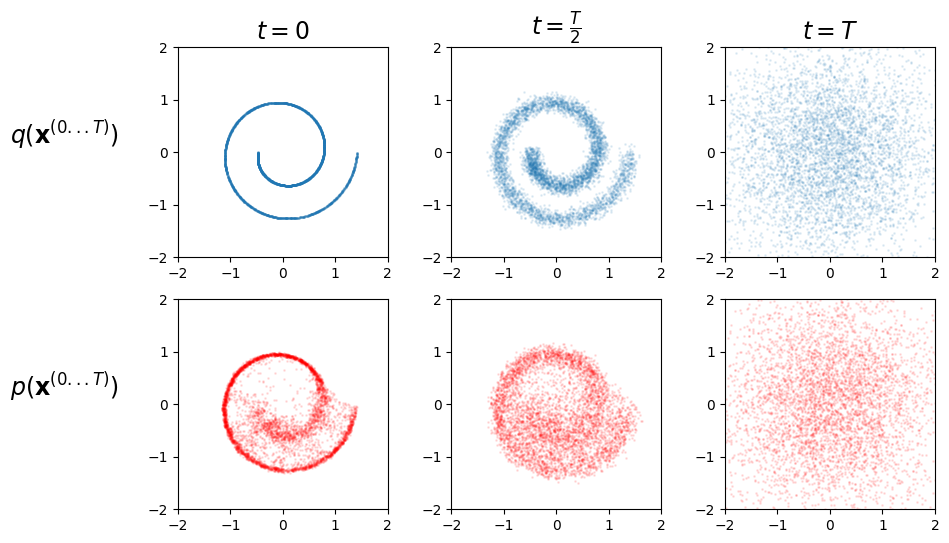

In [ ]:
plot_3(diffusion_model)
# https://medium.com/@dtoka/understanding-and-reproducing-the-2015-initial-diffusion-models-0a743b2ef390

In [ ]:
def plot_5(model):
    plt.figure(figsize=(10, 6))
    x0 = sample_batch(5000)
    x10 = model.forward_process(torch.from_numpy(x0).to(device), 10)[-1].data.cpu().numpy()
    x20 = model.forward_process(torch.from_numpy(x0).to(device), 20)[-1].data.cpu().numpy()
    x30 = model.forward_process(torch.from_numpy(x0).to(device), 30)[-1].data.cpu().numpy()
    x40 = model.forward_process(torch.from_numpy(x0).to(device), 40)[-1].data.cpu().numpy()
    data = [x0, x10, x20, x30, x40]
    for i, t in enumerate([0, 10, 20, 30, 39]):
        plt.subplot(2, 5, 1 + i)
        plt.scatter(data[i][:, 0], data[i][:, 1], alpha=.1, s=1)
        plt.xlim([-2, 2])
        plt.ylim([-2, 2])
        plt.gca().set_aspect('equal')
        if t == 0: plt.ylabel(r'$q(\mathbf{x}^{(0...T)})$', fontsize=17, rotation=0, labelpad=60)
        if i == 0: plt.title(r'$t=0$', fontsize=17)
        if i == 1: plt.title(r'$t=\frac{T}{4}$', fontsize=17)
        if i == 2: plt.title(r'$t=\frac{T}{2}$', fontsize=17)
        if i == 3: plt.title(r'$t=\frac{3T}{4}$', fontsize=17)
        if i == 4: plt.title(r'$t=T$', fontsize=17)

    samples = model.sample(5000, device)
    for i, t in enumerate([0, 10, 20, 30, 40]):
        plt.subplot(2, 5, 6 + i)
        plt.scatter(samples[40 - t][:, 0].data.cpu().numpy(), samples[40 - t][:, 1].data.cpu().numpy(),
                    alpha=.1, s=1, c='r')
        plt.xlim([-2, 2])
        plt.ylim([-2, 2])
        plt.gca().set_aspect('equal')
        if t == 0: plt.ylabel(r'$p(\mathbf{x}^{(0...T)})$', fontsize=17, rotation=0, labelpad=60)

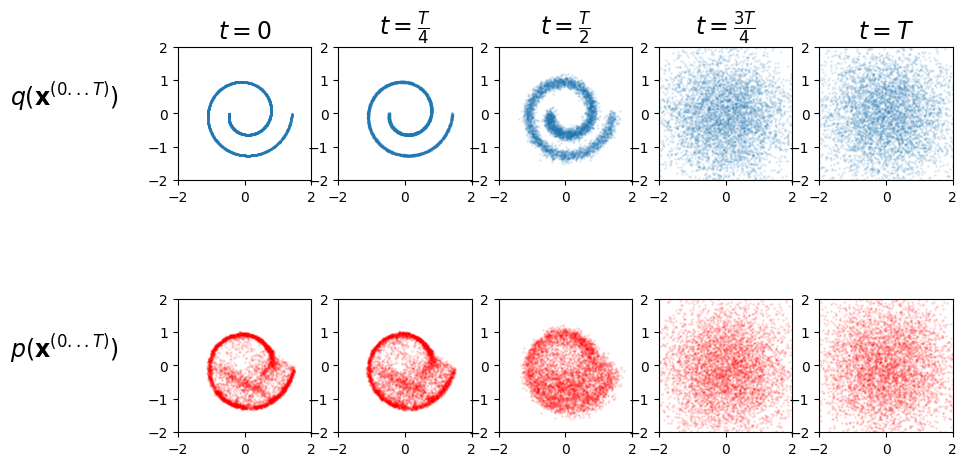

In [ ]:
plot_5(diffusion_model)

# Chapter 2: Understanding the substeps

In [ ]:
import torch
import numpy as np
from torch import nn
from tqdm import tqdm
import torch.utils.data
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

## Dataset

In [19]:
from sklearn.datasets import make_swiss_roll
import numpy as np

def sample_batch(size):
    x, _ = make_swiss_roll(size)
    return x[:, [2, 0]] / 10.0 * np.array([1, -1])

In [21]:
batch_size = 32

original_data = sample_batch(batch_size)
print(original_data.shape)

(32, 2)


## Diffusion Rate

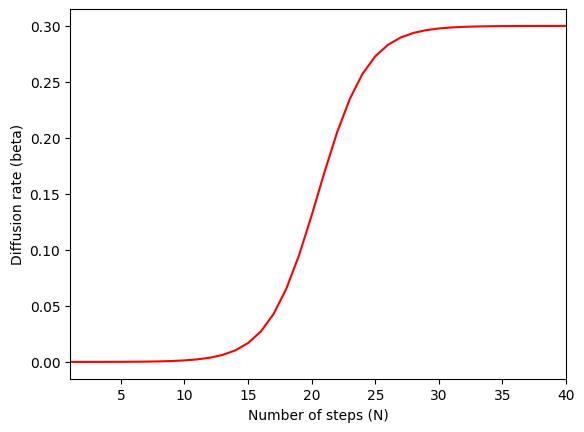

In [1]:
import torch
import matplotlib.pyplot as plt

betas = torch.linspace(-10, 10, 40)
#print("betas: ", betas)
beta = torch.sigmoid(betas) * (3e-1 - 1e-5) + 1e-5
#print("beta: ", beta)

x = torch.arange(1, 41, 1)
#print("steps: ", x)
y = beta
plt.plot(x, y,'r')
plt.xlabel("Number of steps (N)")
plt.ylabel("Diffusion rate (beta)")
plt.xlim(1, 40)
plt.show()

## Forward process

In [3]:
import torch
import numpy as np
from torch import nn
from tqdm import tqdm
import torch.utils.data
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

In [41]:
# Multi-Layer Perceptron
class MLP(nn.Module):

    def __init__(self, N=40, data_dim=2, hidden_dim=64):
        super(MLP, self).__init__()

        self.network_head = nn.Sequential(nn.Linear(data_dim, hidden_dim), nn.ReLU(),
                                          nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), )
        self.network_tail = nn.ModuleList([nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                                         nn.ReLU(), nn.Linear(hidden_dim, data_dim * 2)
                                                         ) for _ in range(N)])

    def forward(self, x, t: int):
        h = self.network_head(x)
        return self.network_tail[t](h)

# Diffusion Model
class DiffusionModel(nn.Module):

    def __init__(self, model: nn.Module, n_steps=40, device='cuda'):
        super().__init__()

        self.model = model
        self.device = device

        betas = torch.linspace(-18, 10, n_steps)
        self.beta = torch.sigmoid(betas) * (3e-1 - 1e-5) + 1e-5 # diffusion rate

        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0) # cumulative product of alphas
        self.n_steps = n_steps
        self.sigma2 = self.beta

    def forward_process(self, x0, t):

        t = t - 1  # Start indexing at 0
        beta_forward = self.beta[t]
        alpha_forward = self.alpha[t]
        alpha_cum_forward = self.alpha_bar[t]
        xt = x0 * torch.sqrt(alpha_cum_forward) + torch.randn_like(x0) * torch.sqrt(1. - alpha_cum_forward)
        # Retrieved from https://github.com/Sohl-Dickstein/Diffusion-Probabilistic-Models/blob/master/model.py#L203
        mu1_scl = torch.sqrt(alpha_cum_forward / alpha_forward)
        mu2_scl = 1. / torch.sqrt(alpha_forward)
        cov1 = 1. - alpha_cum_forward / alpha_forward
        cov2 = beta_forward / alpha_forward
        lam = 1. / cov1 + 1. / cov2
        mu = (x0 * mu1_scl / cov1 + xt * mu2_scl / cov2) / lam
        sigma = torch.sqrt(1. / lam)
        return mu, sigma, xt

    def reverse(self, xt, t):

        t = t - 1  # Start indexing at 0
        if t == 0: return None, None, xt
        mu, h = self.model(xt, t).chunk(2, dim=1)
        sigma = torch.sqrt(torch.exp(h))
        samples = mu + torch.randn_like(xt) * sigma
        return mu, sigma, samples

    def sample(self, size, device):
        noise = torch.randn((size, 2)).to(device)
        samples = [noise]
        for t in range(self.n_steps):
            _, _, x = self.reverse(samples[-1], self.n_steps - t - 1 + 1)
            samples.append(x)
        return samples

# Plotting the forward process
def plot_forward_process(model):
    plt.figure(figsize=(15, 15))
    x0 = sample_batch(5000)
    x5 = model.forward_process(torch.from_numpy(x0).to(device), 5)[-1].data.cpu().numpy()
    x10 = model.forward_process(torch.from_numpy(x0).to(device), 10)[-1].data.cpu().numpy()
    x15 = model.forward_process(torch.from_numpy(x0).to(device), 15)[-1].data.cpu().numpy()
    x20 = model.forward_process(torch.from_numpy(x0).to(device), 20)[-1].data.cpu().numpy()
    x25 = model.forward_process(torch.from_numpy(x0).to(device), 25)[-1].data.cpu().numpy()
    x30 = model.forward_process(torch.from_numpy(x0).to(device), 30)[-1].data.cpu().numpy()
    x35 = model.forward_process(torch.from_numpy(x0).to(device), 25)[-1].data.cpu().numpy()
    x40 = model.forward_process(torch.from_numpy(x0).to(device), 40)[-1].data.cpu().numpy()
    data = [x0, x5, x10, x15, x20, x25, x30, x35, x40]
    for i, t in enumerate([0, 5, 10, 15, 20, 25, 30, 35, 39]):
        plt.subplot(1, 9, 1 + i)
        plt.scatter(data[i][:, 0], data[i][:, 1], alpha=.1, s=1)
        plt.xlim([-2, 2])
        plt.ylim([-2, 2])
        plt.gca().set_aspect('equal')
        if t == 0: plt.ylabel(r'$q(\mathbf{x}^{(0...T)})$', fontsize=17, rotation=0, labelpad=60)
        if i == 0: plt.title(r'$t=0$', fontsize=17)
        if i == 1: plt.title(r'$t=5$', fontsize=17)
        if i == 2: plt.title(r'$t=10$', fontsize=17)
        if i == 3: plt.title(r'$t=15$', fontsize=17)
        if i == 4: plt.title(r'$t=20$', fontsize=17)
        if i == 5: plt.title(r'$t=25$', fontsize=17)
        if i == 6: plt.title(r'$t=30$', fontsize=17)
        if i == 7: plt.title(r'$t=35$', fontsize=17)
        if i == 8: plt.title(r'$t=40$', fontsize=17)

# Plotting the reverse process
def plot_reverse_process(model):
    plt.figure(figsize=(15, 15))
    samples = model.sample(5000, device)
    for i, t in enumerate([0, 5, 10, 15, 20, 25, 30, 35, 40]):
        plt.subplot(1, 9, 1 + i)
        plt.scatter(samples[40 - t][:, 0].data.cpu().numpy(), samples[40 - t][:, 1].data.cpu().numpy(),
                    alpha=.1, s=1, c='r')
        plt.xlim([-2, 2])
        plt.ylim([-2, 2])
        plt.gca().set_aspect('equal')
        if t == 0: plt.ylabel(r'$p(\mathbf{x}^{(0...T)})$', fontsize=17, rotation=0, labelpad=60)
        if i == 0: plt.title(r'$t=0$', fontsize=17)
        if i == 1: plt.title(r'$t=5$', fontsize=17)
        if i == 2: plt.title(r'$t=10$', fontsize=17)
        if i == 3: plt.title(r'$t=15$', fontsize=17)
        if i == 4: plt.title(r'$t=20$', fontsize=17)
        if i == 5: plt.title(r'$t=25$', fontsize=17)
        if i == 6: plt.title(r'$t=30$', fontsize=17)
        if i == 7: plt.title(r'$t=35$', fontsize=17)
        if i == 8: plt.title(r'$t=40$', fontsize=17)
    plt.show()

# sample a batch
def sample_batch(size):
    x, _ = make_swiss_roll(size)
    return x[:, [2, 0]] / 10.0 * np.array([1, -1])

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_mlp = MLP(hidden_dim=128).to(device)
diffusion_model = DiffusionModel(model_mlp)
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=1e-4)

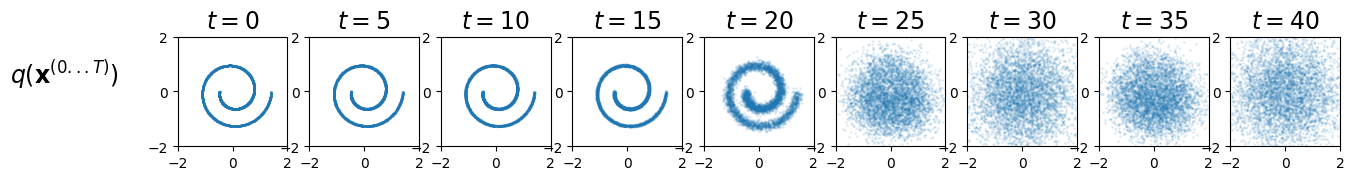

In [42]:
plot_forward_process(diffusion_model)

In [85]:
x0 = sample_batch(5000) # pick 5000 points, with two dimensional coordinates
x5 = diffusion_model.forward_process(torch.from_numpy(x0).to(device), 5)[-1].data.cpu().numpy()
x10 = diffusion_model.forward_process(torch.from_numpy(x0).to(device), 10)[-1].data.cpu().numpy()
x15 = diffusion_model.forward_process(torch.from_numpy(x0).to(device), 15)[-1].data.cpu().numpy()

example_forward = diffusion_model.forward_process(torch.from_numpy(x0).to(device), 5) # check what is happening at step 5
mu, sigma, x5 = example_forward
print(mu.shape) # 5000 values of mu, one per dimension
print(sigma)
print(x5.shape) # 5000 new values as the result of the (slight) diffusion operation
#print(x0)
#print(x5)
#print(example_forward[-1])

torch.Size([5000, 2])
tensor(0.0028)
torch.Size([5000, 2])


In [83]:
import scipy.stats as stats

def plot_gaussian_distribution(mu_array, sigma):

    fig, axs = plt.subplots(1, 2, figsize=(10, 2))
    fig.subplots_adjust(hspace=0.2, wspace=0.5)
    for i in range(2):
      mu = mu_array[i]
      x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
      y = stats.norm.pdf(x, mu, sigma)
      axs[i].plot(x, y)
      subtitle = "Distribution of dimension "+str(i+1)
      axs[i].set_title(subtitle)

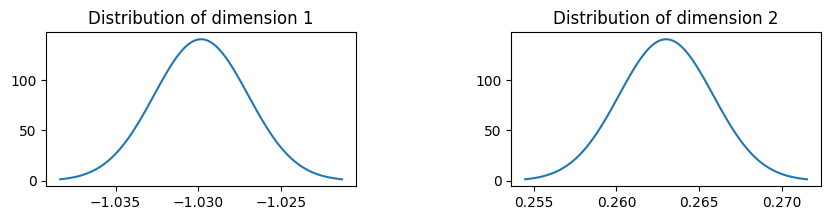

In [84]:
# at each step, we pick each point and add noise to each dimension for this point
mean_values = mu[1].data.cpu().numpy()
plot_gaussian_distribution(mean_values, sigma)

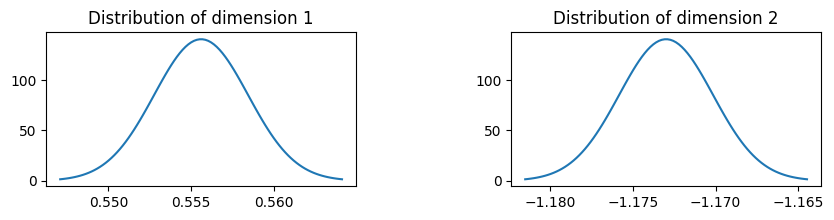

In [88]:
mean_values = mu[5000-1].data.cpu().numpy()
plot_gaussian_distribution(mean_values, sigma)

## Reverse process

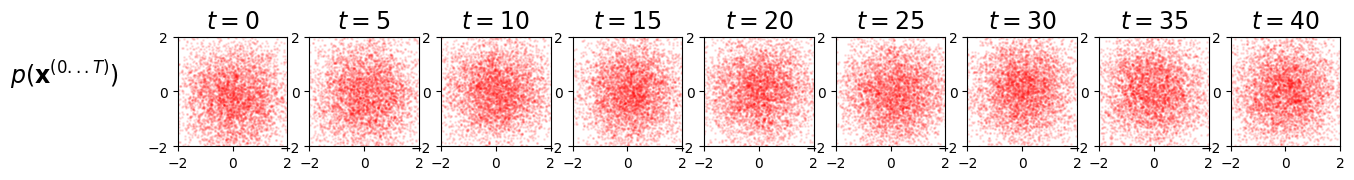

In [43]:
plot_reverse_process(diffusion_model) # without any training the model has not learned anything yet

# Chapter 3: Loading a checkpoint and re-runing a trained model

In [ ]:
# from
import torch
import numpy as np
from torch import nn
from tqdm import tqdm
import torch.utils.data
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

In [ ]:
# Multi-Layer Perceptron
class MLP(nn.Module):

    def __init__(self, N=40, data_dim=2, hidden_dim=64):
        super(MLP, self).__init__()

        self.network_head = nn.Sequential(nn.Linear(data_dim, hidden_dim), nn.ReLU(),
                                          nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), )
        self.network_tail = nn.ModuleList([nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                                         nn.ReLU(), nn.Linear(hidden_dim, data_dim * 2)
                                                         ) for _ in range(N)])

    def forward(self, x, t: int):
        h = self.network_head(x)
        return self.network_tail[t](h)

# Diffusion Model
class DiffusionModel(nn.Module):

    def __init__(self, model: nn.Module, n_steps=40, device='cuda'):
        super().__init__()

        self.model = model
        self.device = device

        betas = torch.linspace(-18, 10, n_steps)
        self.beta = torch.sigmoid(betas) * (3e-1 - 1e-5) + 1e-5 # diffusion rate

        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0) # cumulative product of alphas
        self.n_steps = n_steps
        self.sigma2 = self.beta

    def forward_process(self, x0, t):

        t = t - 1  # Start indexing at 0
        beta_forward = self.beta[t]
        alpha_forward = self.alpha[t]
        alpha_cum_forward = self.alpha_bar[t]
        xt = x0 * torch.sqrt(alpha_cum_forward) + torch.randn_like(x0) * torch.sqrt(1. - alpha_cum_forward)
        # Retrieved from https://github.com/Sohl-Dickstein/Diffusion-Probabilistic-Models/blob/master/model.py#L203
        mu1_scl = torch.sqrt(alpha_cum_forward / alpha_forward)
        mu2_scl = 1. / torch.sqrt(alpha_forward)
        cov1 = 1. - alpha_cum_forward / alpha_forward
        cov2 = beta_forward / alpha_forward
        lam = 1. / cov1 + 1. / cov2
        mu = (x0 * mu1_scl / cov1 + xt * mu2_scl / cov2) / lam
        sigma = torch.sqrt(1. / lam)
        return mu, sigma, xt

    def reverse(self, xt, t):

        t = t - 1  # Start indexing at 0
        if t == 0: return None, None, xt
        mu, h = self.model(xt, t).chunk(2, dim=1)
        sigma = torch.sqrt(torch.exp(h))
        samples = mu + torch.randn_like(xt) * sigma
        return mu, sigma, samples

    def sample(self, size, device):
        noise = torch.randn((size, 2)).to(device)
        samples = [noise]
        for t in range(self.n_steps):
            _, _, x = self.reverse(samples[-1], self.n_steps - t - 1 + 1)
            samples.append(x)
        return samples

# Plotting the forward process
def plot_forward_process(model):
    plt.figure(figsize=(15, 15))
    x0 = sample_batch(5000)
    x5 = model.forward_process(torch.from_numpy(x0).to(device), 5)[-1].data.cpu().numpy()
    x10 = model.forward_process(torch.from_numpy(x0).to(device), 10)[-1].data.cpu().numpy()
    x15 = model.forward_process(torch.from_numpy(x0).to(device), 15)[-1].data.cpu().numpy()
    x20 = model.forward_process(torch.from_numpy(x0).to(device), 20)[-1].data.cpu().numpy()
    x25 = model.forward_process(torch.from_numpy(x0).to(device), 25)[-1].data.cpu().numpy()
    x30 = model.forward_process(torch.from_numpy(x0).to(device), 30)[-1].data.cpu().numpy()
    x35 = model.forward_process(torch.from_numpy(x0).to(device), 25)[-1].data.cpu().numpy()
    x40 = model.forward_process(torch.from_numpy(x0).to(device), 40)[-1].data.cpu().numpy()
    data = [x0, x5, x10, x15, x20, x25, x30, x35, x40]
    for i, t in enumerate([0, 5, 10, 15, 20, 25, 30, 35, 39]):
        plt.subplot(1, 9, 1 + i)
        plt.scatter(data[i][:, 0], data[i][:, 1], alpha=.1, s=1)
        plt.xlim([-2, 2])
        plt.ylim([-2, 2])
        plt.gca().set_aspect('equal')
        if t == 0: plt.ylabel(r'$q(\mathbf{x}^{(0...T)})$', fontsize=17, rotation=0, labelpad=60)
        if i == 0: plt.title(r'$t=0$', fontsize=17)
        if i == 1: plt.title(r'$t=5$', fontsize=17)
        if i == 2: plt.title(r'$t=10$', fontsize=17)
        if i == 3: plt.title(r'$t=15$', fontsize=17)
        if i == 4: plt.title(r'$t=20$', fontsize=17)
        if i == 5: plt.title(r'$t=25$', fontsize=17)
        if i == 6: plt.title(r'$t=30$', fontsize=17)
        if i == 7: plt.title(r'$t=35$', fontsize=17)
        if i == 8: plt.title(r'$t=40$', fontsize=17)

# Plotting the reverse process
def plot_reverse_process(model):
    plt.figure(figsize=(15, 15))
    samples = model.sample(5000, device)
    for i, t in enumerate([0, 5, 10, 15, 20, 25, 30, 35, 40]):
        plt.subplot(1, 9, 1 + i)
        plt.scatter(samples[40 - t][:, 0].data.cpu().numpy(), samples[40 - t][:, 1].data.cpu().numpy(),
                    alpha=.1, s=1, c='r')
        plt.xlim([-2, 2])
        plt.ylim([-2, 2])
        plt.gca().set_aspect('equal')
        if t == 0: plt.ylabel(r'$p(\mathbf{x}^{(0...T)})$', fontsize=17, rotation=0, labelpad=60)
        if i == 0: plt.title(r'$t=0$', fontsize=17)
        if i == 1: plt.title(r'$t=5$', fontsize=17)
        if i == 2: plt.title(r'$t=10$', fontsize=17)
        if i == 3: plt.title(r'$t=15$', fontsize=17)
        if i == 4: plt.title(r'$t=20$', fontsize=17)
        if i == 5: plt.title(r'$t=25$', fontsize=17)
        if i == 6: plt.title(r'$t=30$', fontsize=17)
        if i == 7: plt.title(r'$t=35$', fontsize=17)
        if i == 8: plt.title(r'$t=40$', fontsize=17)
    plt.show()

# sample a batch
def sample_batch(size):
    x, _ = make_swiss_roll(size)
    return x[:, [2, 0]] / 10.0 * np.array([1, -1])

In [ ]:
# Loading the checkpoint
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint_path = '/content/diff_model_original.pt'

# load the weights of the trained model
checkpoint = torch.load(checkpoint_path, weights_only=True)

model_mlp_trained = MLP(hidden_dim=128).to(device)
model_mlp_trained.load_state_dict(checkpoint['weights'])


<All keys matched successfully>

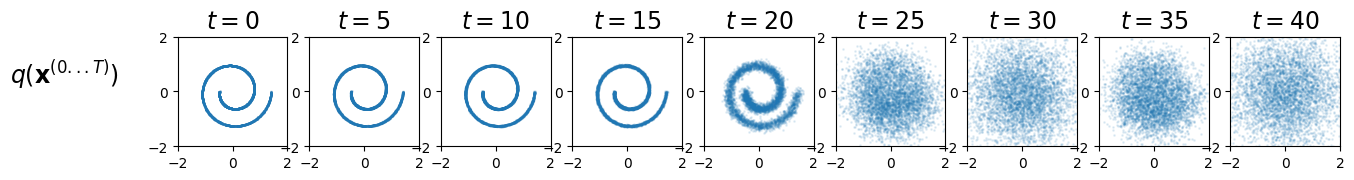

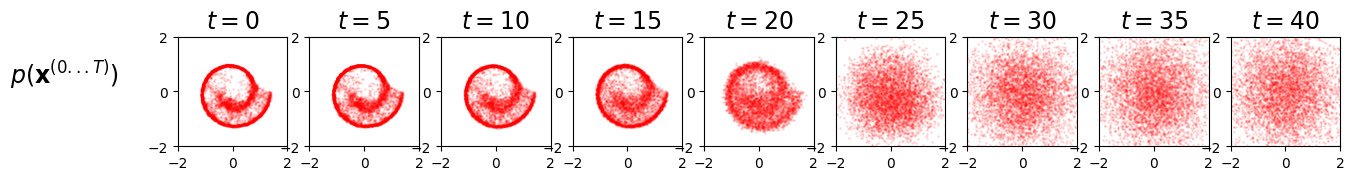

In [ ]:
diffusion_model = DiffusionModel(model_mlp_trained)
plot_forward_process(diffusion_model)
plot_reverse_process(diffusion_model)